# Tutorial: Create a improvised RAG Piepline with Embedders using Haystack


## Installation


In [ ]:
# Run it for the first time alone
# %%bash

# pip install haystack-ai

## Import necessary libraries


In [3]:
import os
import requests
from getpass import getpass

from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack.components.embedders import OpenAITextEmbedder, OpenAIDocumentEmbedder
from haystack.components.retrievers.in_memory import (
    InMemoryEmbeddingRetriever,
)

from haystack import Pipeline

/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gathering data


In [2]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
document_store_with_embedded_data = InMemoryDocumentStore(
    embedding_similarity_function="cosine"
)

baseURL = "https://www.themealdb.com/api/json/v1/1/search.php?f="
alphabet = input("Enter your favourite alphabet: ")

# To handle user input
if len(alphabet) > 0:
    alphabet = alphabet[0]

data = requests.get(url=baseURL + alphabet)
data = data.json()

## Creating Documents


In [3]:
documents = []

for i in range(len(data["meals"])):
    title = data["meals"][i]["strMeal"]
    instructions = data["meals"][i]["strInstructions"]

    documents.append(
        Document(
            content="Title: " + title + "\nMaking Instructions: " + instructions,
            meta={
                "cuisine": data["meals"][i]["strCategory"]
                + " "
                + data["meals"][i]["strArea"],
                "url": data["meals"][i]["strYoutube"],
            },
        )
    )

In [4]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")

### Embedding & Storing the documents


In [5]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
document_embedder = OpenAIDocumentEmbedder()
documents_with_embeddings = document_embedder.run(documents=documents)["documents"]
document_store.write_documents(documents_with_embeddings)

Calculating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


13

## Query Pipeline


In [6]:
query_retrieval_pipeline = Pipeline()

text_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=3)

query_retrieval_pipeline.add_component("text_embedder", text_embedder)
query_retrieval_pipeline.add_component("retriever", retriever)

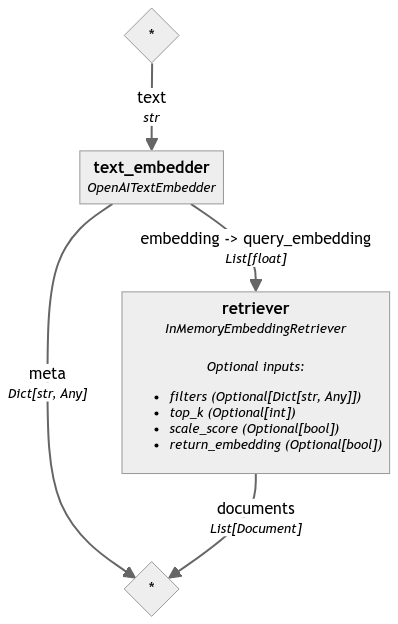

In [10]:
query_retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

## Output


In [15]:
query = input("Enter the question: ")

result = query_retrieval_pipeline.run(
    {
        "text_embedder": {"text": query},
        # "retriever": {"query_embedding": query}
    }
)

print("Retriever with Embeddings Results:\n")
for doc in result["retriever"]["documents"]:
    print(doc)
    print()

Retriever with Embeddings Results:

Document(id=daa29972627d0b5b1b7324623496257496a2eef832ce222ba8ee7037a436b393, content: 'Title: Rigatoni with fennel sausage sauce
Making Instructions: Heat a tablespoon of oil in a large s...', meta: {'cuisine': 'Lamb Italian', 'url': 'https://www.youtube.com/watch?v=45dpOfESxr8'}, score: 0.809939662595533)

Document(id=a2074f83058dbddcadb88297eed75b1a3535b17d0c5ee04906e2b467384d8372, content: 'Title: Ribollita
Making Instructions: Put 2 tablespoons of the oil in a large pot over medium heat. ...', meta: {'cuisine': 'Vegetarian Italian', 'url': 'https://www.youtube.com/watch?v=BiQUYTBb6eQ'}, score: 0.7911402790990085)

Document(id=e2bc92a7bbc5c62349185eb3ad8f55145c3f1cfe36568b8bceb79afc3b50ca09, content: 'Title: Roast fennel and aubergine paella
Making Instructions: 1 Put the fennel, aubergine, pepper an...', meta: {'cuisine': 'Vegan Spanish', 'url': 'https://www.youtube.com/watch?v=H5SmjR-fxUs'}, score: 0.7737515697004129)



## Deployment


### Get the pipeline created in YAML format

The reason is hayhooks supports deployment of pipelines through YAML/YML format. Then save this file locally.


In [20]:
# Just in case you updated the pipeline just try to
data = query_retrieval_pipeline.dumps()

In [21]:
data

"components:\n  retriever:\n    init_parameters:\n      document_store:\n        init_parameters:\n          bm25_algorithm: BM25L\n          bm25_parameters: {}\n          bm25_tokenization_regex: (?u)\\b\\w\\w+\\b\n          embedding_similarity_function: cosine\n        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore\n      filters: null\n      return_embedding: false\n      scale_score: false\n      top_k: 3\n    type: haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever\n  text_embedder:\n    init_parameters:\n      api_base_url: null\n      api_key:\n        env_vars:\n        - OPENAI_API_KEY\n        strict: true\n        type: env_var\n      dimensions: null\n      model: text-embedding-ada-002\n      organization: null\n      prefix: ''\n      suffix: ''\n    type: haystack.components.embedders.openai_text_embedder.OpenAITextEmbedder\nconnections:\n- receiver: retriever.query_embedding\n  sender: text_embedder.e

In [22]:
pipeline_file = open("tests/pipeline.yml", "w")
pipeline_file.writelines(data)

## Intresting

In [5]:
pipeline_yaml = """
components:
  retriever:
    init_parameters:
      document_store:
        init_parameters:
          bm25_algorithm: BM25L
          bm25_parameters: {}
          bm25_tokenization_regex: (?u)
          embedding_similarity_function: cosine
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      filters: null
      return_embedding: false
      scale_score: false
      top_k: 3
    type: haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever
  text_embedder:
    init_parameters:
      api_base_url: null
      api_key:
        env_vars:
        - OPENAI_API_KEY
        strict: true
        type: env_var
      dimensions: null
      model: text-embedding-ada-002
      organization: null
      prefix: ''
      suffix: ''
    type: haystack.components.embedders.openai_text_embedder.OpenAITextEmbedder
connections:
- receiver: retriever.query_embedding
  sender: text_embedder.embedding
max_loops_allowed: 100
metadata: {}
"""

# bm25_tokenization_regex: (?u)\b\w\w+\b

In [8]:
pipe = Pipeline.loads(pipeline_yaml)

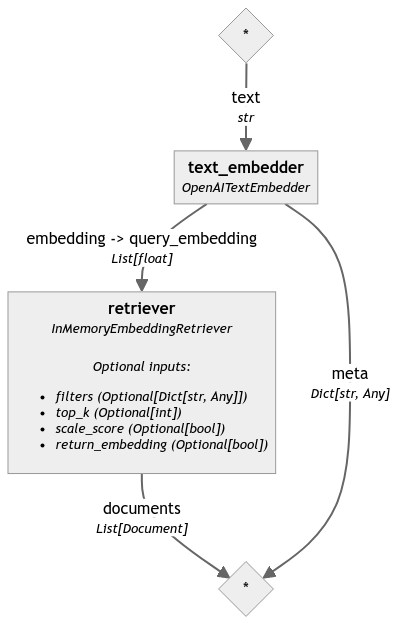

In [7]:
pipe